In [20]:
!tree -d

.
└── fer2013
    ├── test
    │   ├── happy
    │   ├── neutral
    │   └── sad
    └── train
        ├── happy
        ├── neutral
        └── sad

9 directories


In [21]:
train_path = "fer2013/train" 
valid_path = "fer2013/test"  

In [22]:
import os

train_classes = {}
for x in os.listdir(train_path):
  train_classes[x] = len(os.listdir(train_path+"/"+x))
valid_classes = {}
for x in os.listdir(valid_path):
  valid_classes[x] = len(os.listdir(valid_path+"/"+x))

print(train_classes)
print(valid_classes)

{'happy': 7215, 'sad': 4830, 'neutral': 4965}
{'happy': 1774, 'sad': 1247, 'neutral': 1233}


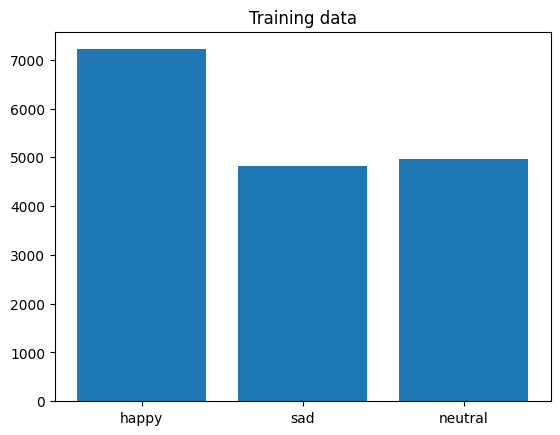

In [24]:
import matplotlib.pyplot as plt
plt.bar(train_classes.keys(),train_classes.values())
plt.title("Training data")
plt.show()

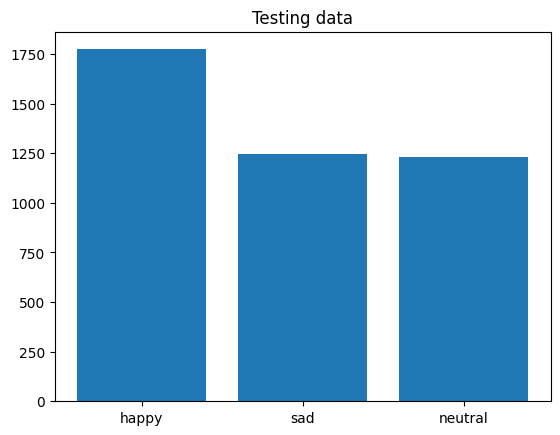

In [25]:
plt.bar(valid_classes.keys(),valid_classes.values())
plt.title("Testing data")
plt.show()

In [26]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [66]:
import gc
gc.collect()

11636

In [78]:
from tqdm import tqdm 
X_train = []
Y_train = []
X_val = []
Y_val = []
for cls in os.listdir(train_path):
    for file in tqdm(os.listdir(train_path+'/'+cls)):
        img = load_img(train_path+'/'+cls+'/'+file, color_mode='grayscale')
        X_train.append(img_to_array(img).flatten() / 255.0)  #NORMALIZE
        Y_train.append(cls)
for cls in os.listdir(valid_path):
    for file in tqdm(os.listdir(valid_path+'/'+cls)):
        img = load_img(valid_path+'/'+cls+'/'+file, color_mode='grayscale')
        X_val.append(img_to_array(img).flatten() / 255.0)
        Y_val.append(cls)

100%|██████████| 1233/1233 [00:00<00:00, 4883.92it/s]


In [79]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_re, Y_train_re = sm.fit_resample(X_train, Y_train)

In [80]:
print("happy\t",Y_train_re.count('happy'))
print("neutral\t",Y_train_re.count('neutral'))
print("sad\t",Y_train_re.count('sad'))

happy	 7215
neutral	 7215
sad	 7215


In [81]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train_re)
Y_train_l = le.transform(Y_train_re)
Y_val_l = le.transform(Y_val)

In [82]:
Y_train_l_org = Y_train_l
Y_val_l_org = Y_val_l

#Normalization
X_train = np.array(X_train_re) #NUMPY ARRAY
X_val = np.array(X_val)

Y_train = to_categorical(Y_train_l, 3)
Y_val = to_categorical(Y_val_l, 3)

#Reshape
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)



In [83]:
X_train.shape

(21645, 48, 48, 1)

In [84]:
from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, BatchNormalization
import tensorflow as tf

In [85]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 128)      

In [86]:
import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger

chk_path = 'cnn_new.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss') #PERIODICALLY SAVE, BEST MODEL 

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger, earlystop]

In [87]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy','AUC'])

In [88]:
gc.collect()

1354

In [89]:
history = model.fit(X_train, Y_train, batch_size = 64,validation_data = (X_val, Y_val),
                 epochs=100,
                 callbacks=callbacks)

Epoch 1/100


2023-05-12 12:54:29.307980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


339/339 [==============================] - ETA: 0s - loss: 6.3522 - accuracy: 0.4271 - auc: 0.6069
Epoch 1: val_loss improved from inf to 2.22441, saving model to cnn_new.h5
339/339 [==============================] - 22s 49ms/step - loss: 6.3522 - accuracy: 0.4271 - auc: 0.6069 - val_loss: 2.2244 - val_accuracy: 0.2880 - val_auc: 0.5206 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - ETA: 0s - loss: 1.8558 - accuracy: 0.5964 - auc: 0.7968
Epoch 2: val_loss improved from 2.22441 to 2.19847, saving model to cnn_new.h5
339/339 [==============================] - 15s 44ms/step - loss: 1.8558 - accuracy: 0.5964 - auc: 0.7968 - val_loss: 2.1985 - val_accuracy: 0.3834 - val_auc: 0.5658 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - ETA: 0s - loss: 1.6147 - accuracy: 0.6630 - auc: 0.8482
Epoch 3: val_loss improved from 2.19847 to 1.80649, saving model to cnn_new.h5
339/339 [==============================] - 15s 45ms/step - loss: 1.6147 - accuracy: 0.6630

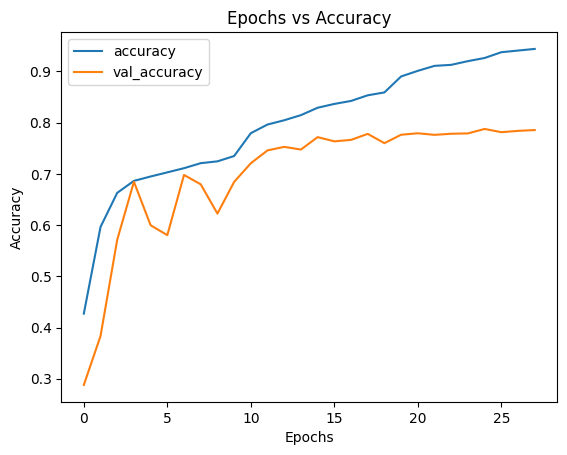

In [90]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'],label="accuracy")
plt.plot(history.history['val_accuracy'],label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Epochs vs Accuracy")
plt.show()

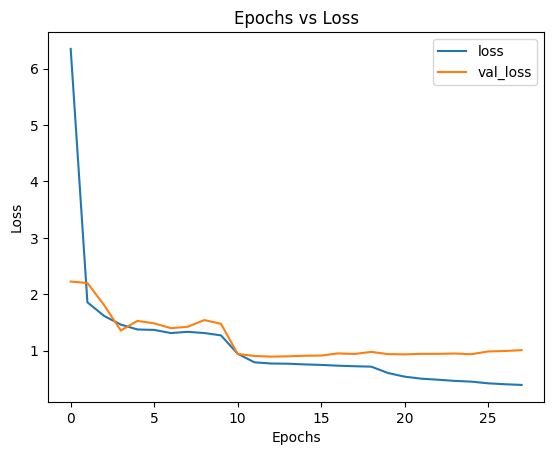

In [91]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Epochs vs Loss")
plt.show()

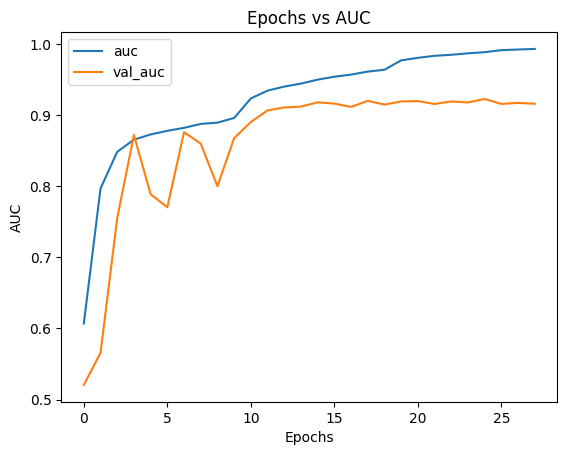

In [92]:
import matplotlib.pyplot as plt 
plt.plot(history.history['auc'],label="auc")
plt.plot(history.history['val_auc'],label="val_auc")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.title("Epochs vs AUC")
plt.show()

In [54]:
model.evaluate(
    x=X_val,
    y=Y_val,
    batch_size=64,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False
)

67/67 [==============================] - 1s 12ms/step - loss: 0.7703 - accuracy: 0.7788 - auc: 0.9231


[0.7702609896659851, 0.7787964344024658, 0.9231401681900024]

In [55]:
pred = model.predict(X_val)

133/133 [==============================] - 1s 6ms/step


In [56]:
true_class = np.argmax(Y_val,axis=1)

In [57]:
import numpy as np
pred_class = np.argmax(pred,axis=1)
print(pred_class[:5])
print(true_class[:5])

[0 0 0 0 0]
[0 0 0 0 0]


In [58]:
from sklearn import metrics

print('Accuracy :',metrics.accuracy_score(true_class,pred_class))

Accuracy : 0.7787964268923366


In [59]:
print(metrics.classification_report(true_class,pred_class))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1774
           1       0.70      0.66      0.68      1233
           2       0.67      0.78      0.72      1247

    accuracy                           0.78      4254
   macro avg       0.77      0.77      0.76      4254
weighted avg       0.79      0.78      0.78      4254



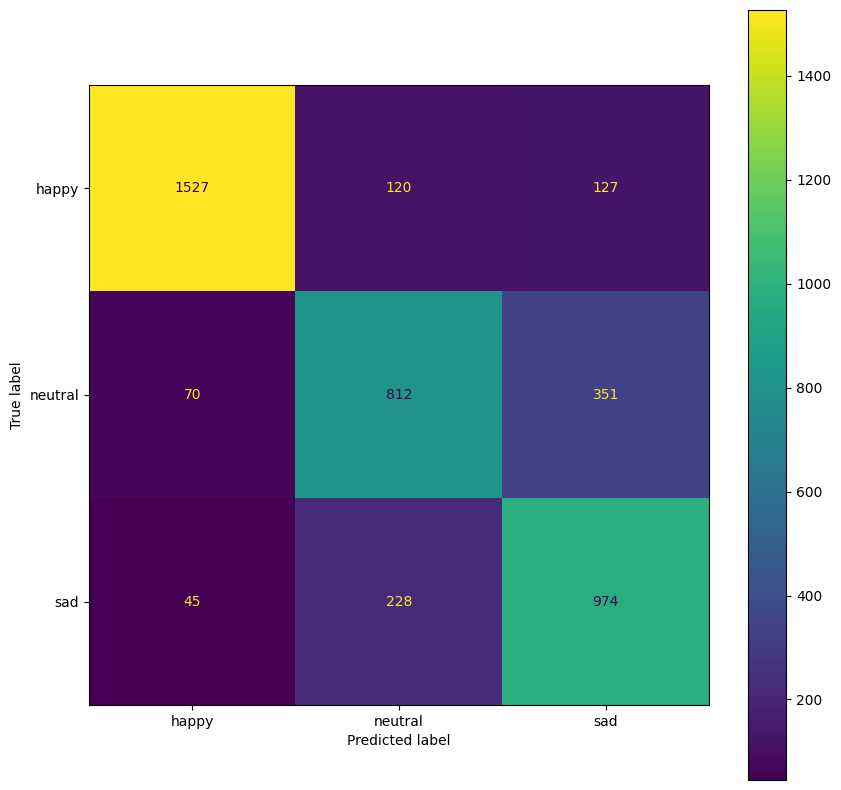

In [60]:
import os
import matplotlib.pyplot as plt 

cm = metrics.confusion_matrix(true_class, pred_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted(os.listdir(train_path)))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()